In [2]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical
import math
import torch.nn as nn

In [3]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_info = env.action_space
print(env.observation_space.shape, obs_dim, action_info)

(3,) 3 Box(-2.0, 2.0, (1,), float32)


In [4]:
class ActionNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(ActionNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)
    
class QValueNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        '''状态价值，用来评估动作的好坏程度'''
        super(QValueNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim + out_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, 1)
        )
        
    def forward(self, x: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        t = torch.cat([x, a], 0)
        return self.layers(t)

In [5]:
actor = ActionNetwork(obs_dim, 1)
critic = QValueNetwork(obs_dim, 1)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)

In [6]:
def select_action(state):
    '''策略网络做出决策，给出一个动作'''
    action = actor(torch.FloatTensor(state).to(device))
    return action.cpu().data.numpy().flatten()

def critic_value(state, action):
    return critic(torch.FloatTensor(state).to(device), torch.FloatTensor(action).to(device))

In [7]:
gamma = 0.98

steps = []
scores = []
view_losses = []
max_epoch = 1000
for i in range(max_epoch):
    score = 0
    step = 0
    
    state, _ = env.reset(seed=3)
    trajectories = []
    while True:
        '''让策略网络做预测'''
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(np.float32(action))
        done = terminated or truncated
        
        step += 1
        score += reward
        
        trajectories.append([state, action, reward, next_state, done])
        if done or step > 200:
            steps.append(step)
            scores.append(score)
            break
        
        state = next_state
        
    # 结束一轮游戏
    for state, action, reward, next_state, done in trajectories[::-1]:        
        mask = 1 - done
#         print('---------', torch.tensor(state), action, torch.tensor(state).shape, action.shape)
#         '''让价值网络做预测'''
#         result = torch.cat([torch.tensor(state), action], 0)
#         print('---------', result)
        q_t = critic_value(state, action)
        
        next_action = select_action(next_state)
        next_q_t = critic_value(next_state, next_action)
        '''计算价值网络的 TD 目标和 TD 误差'''
        y_t = reward + gamma * next_q_t * mask
#         print(q_t, y_t)
        critic_loss = F.smooth_l1_loss(q_t, y_t)
        '''更新价值网络'''
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
        new_action = select_action(state)
        actor_loss = -critic_value(state, new_action)
    
        '''更新策略网络'''
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

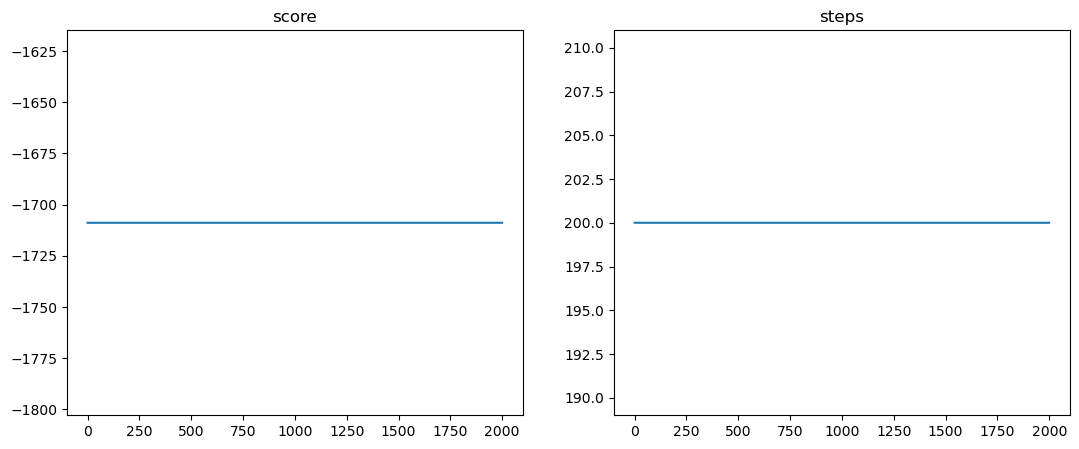

In [8]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()

In [ ]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=3)
    done = False
    score = 0
    step = 0
    while not done:
        action = select_action(state)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/webberg/workspace/code/reinforce_learning/policy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/webberg/workspace/code/reinforce_learning/policy/rl-video-episode-0.mp4
